#Demo de TF-Agents para jugar juegos de Atari usando una red DQN

 Basado en los tutoriales de Tensor Flow: https://www.tensorflow.org/agents/tutorials/2_environments_tutorial

 Clase Agente especial de:  https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb 

In [1]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'agents' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
TF-Agentes instalado.


In [2]:
#@title Instalar Paquetes para acceder a Atari Gym
## Opción 1: bajar ROMs ade http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
#!wget http://www.atarimania.com/roms/Roms.rar
#!mkdir /content/ROM/
#!unrar e /content/Roms.rar /content/ROM/
#!python -m atari_py.import_roms /content/ROM/

## Opción 2: más sencilla
###%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title Instalar Paquetes para visualizar juegos de Atari 
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pyglet


Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [4]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint

import random
import pandas as pd

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import TFPolicy
from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks import q_network, categorical_q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

tf.compat.v1.enable_v2_behavior()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

print("Librerías cargadas.")

Librerías cargadas.


## Entorno para Juego de Atari



- Entorno:  ALE/Pong-v5


- Time Step Spec:
   TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(128,), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


-Action Spec:
   BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))




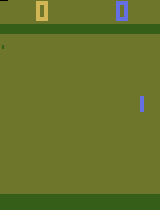

In [5]:
#@title Selecciona el juego de Atari
seleccionaJuego = "Pong" #@param ["Pong", "Freeway", "Enduro", "Asteroids", "Breakout", "Space Invaders"]
#@markdown Ver informacion en https://www.gymlibrary.dev/environments/atari/complete_list/
tipoObsTS = "Game RAM" #@param ["Game RAM", "RGB Screen", "Grayscale Screen"]

# selecciona juego
if seleccionaJuego == "Freeway":
  gym_env_name = 'ALE/Freeway-v5'
elif seleccionaJuego == "Enduro":
  gym_env_name = 'ALE/Enduro-v5'
elif seleccionaJuego == "Pong":
  gym_env_name = 'ALE/Pong-v5'
elif seleccionaJuego == "Asteroids":
  gym_env_name = 'ALE/Asteroids-v5'
elif seleccionaJuego == "Breakout":
  gym_env_name = 'ALE/Breakout-v5'
elif seleccionaJuego == "Space Invaders":
  gym_env_name = 'ALE/SpaceInvaders-v5'
else:
  raise ValueError("No se puede defnir gym_env_name!!!")

# determina tipo de OBS
if tipoObsTS == "Game RAM":
  obsType = 'ram'
elif tipoObsTS == "RGB Screen":
  obsType = 'rgb'
elif tipoObsTS == "Grayscale Screen":
  obsType = 'grayscale'
else:
  raise ValueError("No se puede defnir obsType!!!")  

# librerías especiales
import pyvirtualdisplay
from tf_agents.environments import suite_gym
import PIL.Image
import base64
import imageio
import IPython
import os
import time

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# funciones auxiliares para mostrar 
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <div align="middle">
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video></div>'''.format(b64.decode())
  return IPython.display.HTML(tag)


def generar_animacion_policy(env, envpy, policy, filename, mostrarRecompensa=True, num_episodes=1, fps=32):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for i in range(num_episodes):
      if num_episodes > 1:
        print("Generando episodio " + str(i+1) + "...")
      else:
        print("Generando...")
      # inicia entorno
      time_step = env.reset()
      video.append_data(envpy.render())
      sumR = 0.00
      while not time_step.is_last():
        # hace jugar
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        sumR += time_step.reward.numpy()[0]
        video.append_data(envpy.render())
      # muestra recompensa
      if mostrarRecompensa:
        rFinal = time_step.reward.numpy()[0]
        if num_episodes > 1:
          print("Recompensa Acumulada del episodio " + str(i+1) + ": ", sumR)
          print("Recompensa Final del episodio " + str(i+1) + ": ", rFinal)
        else:
          print("Recompensa Acumulada: ", sumR)
          print("Recompensa Final: ", rFinal)
    video.close()
    ##while not os.path.exists(filename):
    ##  time.sleep(1)
  return embed_mp4(filename)

# crea entornos
train_py_env = suite_gym.load(gym_env_name, gym_kwargs={'obs_type':obsType,'render_mode':'human'})
eval_py_env = suite_gym.load(gym_env_name, gym_kwargs={'obs_type':obsType,'render_mode':'human'})
train_py_env.metadata['render_fps'] = 30
eval_py_env.metadata['render_fps'] = 30
ori_train_py_env = None
ori_eval_py_env = None

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), 
                                                train_env.action_spec())

# muesta información del entorno
print("\n")
print('- Entorno: ', gym_env_name)
print("\n")
print('- Time Step Spec:')
print("  ", eval_env.time_step_spec())
print("\n")
print('-Action Spec:')
print("  ", eval_env.action_spec())
print("\n")

# muestra pantalla ejemplo
eval_env.reset()
PIL.Image.fromarray(eval_py_env.render())

In [6]:
#@title Ejemplo de juego jugando al Azar
generar_animacion_policy(eval_env, eval_py_env, random_policy, "random_policy", True, 1)

Generando...
Recompensa Acumulada:  -21.0
Recompensa Final:  0.0


##DQN

In [7]:
#@title Definir el Agente tipo DQN
entrenar_DQN = True # @param {type:"boolean"}
DQNpolicy = None

if entrenar_DQN:
  tipo_agente = "DQN Categorico (C51)" #@param ["DQN", "DQN Categorico (C51)", "AtariCategoricalQNetwork"]
  learning_rate = 1e-3  # @param {type:"number"}
  cant_neuronas_ocultas = "250, 100, 25" # @param {type:"string"}
  DQNCat_num_atoms = 51  # param {type:"integer"}
  # controla cantidad de atoms para DQN Cat
  if DQNCat_num_atoms <= 1:
    DQNCat_num_atoms = 51

  if obsType == 'ram':
    # como es un vector no se usa CNN
    DQN_agregar_capa_cnn = False
  else:
    # como es una matriz/imagen se usa CNN
    DQN_agregar_capa_cnn = True

  # Define cantidad de neuronas ocultas para RNA-Q
  hidden_layers = []
  for val in cant_neuronas_ocultas.split(','):
    if  int(val) < 1:
      hidden_layers.append( 10 )
    else:
      hidden_layers.append( int(val) )
  fc_layer_params = tuple(hidden_layers, )

  #define las capas convolutional
  if DQN_agregar_capa_cnn:    
    CNN_preprocessing_layers = tf.keras.models.Sequential(
                                        [tf.keras.layers.LayerNormalization(axis=1),
                                        tf.keras.layers.Conv2D(2, 2, activation='relu', padding="same"),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                        tf.keras.layers.Flatten()])
  else:
    CNN_preprocessing_layers = None


  if tipo_agente=="DQN":


    # Define RNA-Q
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        preprocessing_layers=CNN_preprocessing_layers,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.Variable(0)

    # Define el agente de tipo Q
    ag = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN inicializado. ")

  elif tipo_agente == "DQN Categorico (C51)":
    
    # Define RNA-Q Categórico
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=DQNCat_num_atoms,
        preprocessing_layers=CNN_preprocessing_layers,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)
    
    # parámetros especificos (por defecto)
    n_step_update = 2
    gamma = 0.99

    # Define el agente de tipo Q Categórico
    ag = CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter)
    
    ag.initialize()
    
    print("Agente DQN Categorico (C51) inicializado. ")

  elif tipo_agente == "AtariCategoricalQNetwork":
    
    # código copiado de https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb
    from tf_agents.networks import q_network, network
    from tf_agents.agents.categorical_dqn import categorical_dqn_agent
    from tf_agents.networks import categorical_q_network
    from tf_agents.specs import tensor_spec
    import tensorflow as tf

    # AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
    # frames. We need to account for this when computing things like update
    # intervals.
    ATARI_FRAME_SKIP = 4

    class AtariCategoricalQNetwork(network.Network):
        """CategoricalQNetwork subclass that divides observations by 255."""

        def __init__(self, input_tensor_spec, action_spec, **kwargs):
            super(AtariCategoricalQNetwork, self).__init__(
                input_tensor_spec, state_spec=())
            input_tensor_spec = tf.TensorSpec(
                dtype=tf.float32, shape=input_tensor_spec.shape)
            self._categorical_q_network = \
                categorical_q_network.CategoricalQNetwork(
                    input_tensor_spec, action_spec, **kwargs)

        @property
        def num_atoms(self):
            return self._categorical_q_network.num_atoms

        def call(self, observation, step_type=None, network_state=()):
            state = tf.cast(observation, tf.float32)
            # We divide the grayscale pixel values by 255 here rather than
            # storing normalized values beause uint8s are 4x cheaper to
            # store than float32s.
            # TODO(b/129805821): handle the division by 255 for
            # train_eval_atari.py in
            # a preprocessing layer instead.
            state = state / 255
            return self._categorical_q_network(
                state, step_type=step_type, network_state=network_state)
    
    fc_layer_params = (512,)
    
    #define las capas convolutional
    if DQN_agregar_capa_cnn:    
      conv_layer_params = ((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))
    else:
      conv_layer_params = None

    q_net = AtariCategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.RMSPropOptimizer(
        learning_rate=learning_rate,
        decay=0.95,
        momentum=0.0,
        epsilon=0.00001,
        centered=True)

    train_step_counter = tf.Variable(0)

    observation_spec = tensor_spec.from_spec(train_env.observation_spec())
    time_step_spec = ts.time_step_spec(observation_spec)

    action_spec = tensor_spec.from_spec(train_env.action_spec())
    target_update_period = 32000  # ALE frames
    update_period = 16  # ALE frames
    _update_period = update_period / ATARI_FRAME_SKIP


    ag = categorical_dqn_agent.CategoricalDqnAgent(
        time_step_spec,
        action_spec,
        categorical_q_network=q_net,
        optimizer=optimizer,
        # epsilon_greedy=epsilon,
        n_step_update=1.0,
        target_update_tau=1.0,
        target_update_period=(
            target_update_period / ATARI_FRAME_SKIP / _update_period),
        gamma=0.99,
        reward_scale_factor=1.0,
        gradient_clipping=None,
        debug_summaries=False,
        summarize_grads_and_vars=False)

    ag.initialize()

    print("Agente Atari Categorical Q-Network inicializado. ")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  

Agente DQN Categorico (C51) inicializado. 


In [8]:
#@title Métricas para evaluación y Preparar datos para Entrenamiento del Agente DQN

if entrenar_DQN:

  # Definir Métricas para evaluación para Agente DQN
    
  # Se usa el promedio de la recompensa (la más común)
  # See also the metrics module for standard implementations of different metrics.
  # https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

  def compute_avg_return(environment, policy, num_episodes=10):
    if num_episodes == 0:
      return 0.0 
    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  initial_collect_steps = 100  # @param {type:"integer"} 
  collect_steps_per_iteration =   50# @param {type:"integer"}
  replay_buffer_max_length = 100000  # @param {type:"integer"}
  batch_size = 32  # @param {type:"integer"}

  # Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec = ag.collect_data_spec,
      batch_size = train_env.batch_size,
      max_length = replay_buffer_max_length)

  # Recolecta datos generados al azar
  # This loop is so common in RL, that we provide standard implementations. 
  # For more details see the drivers module.
  # https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

  def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

  def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
      collect_step(env, policy, buffer)

  collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

  print("\nDatos recolectados.")

  # Muestra ejemplo de los datos recolectados
  ##iter(replay_buffer.as_dataset()).next()

  # Preparar los datos recolectados con trajectories de shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)
  iterator = iter(dataset)
  # Muestra ejemplo 
  ##iterator.next()
  print("\nDataset creado.")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.



Datos recolectados.

Dataset creado.


In [9]:
#@title Entrenar al Agente DQN

if entrenar_DQN:

  cant_ciclos_entrenamiento_finalizar =  100# @param {type:"integer"}
  log_cada_ciclos = 30  # @param {type:"integer"}
  mostar_recompensa_cada = 50  # @param {type:"integer"}
  cant_episodios_evaluacion =  10# @param {type:"integer"}
  minima_recompensa_promedio_finalizar = 1000 # @param {type:"number"}
  
  #  Optimize by wrapping some of the code in a graph using TF function (Optional)
  ag.train = common.function(ag.train)

  # Reset the train step
  ag.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
  ar_cicloL = []
  ar_cicloR = []
  ar_returns = []
  ar_loss = []

  print("\n** Comienza el Entrenamiento **\n")
  for _ in range(cant_ciclos_entrenamiento_finalizar):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = ag.train(experience).loss

    step = ag.train_step_counter.numpy()

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
      print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
      ar_cicloL.append( step )
      ar_loss.append( train_loss )
    
    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
      ar_cicloR.append( step )
      ar_returns.append( avg_return )
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

      if (avg_return >= minima_recompensa_promedio_finalizar):
        print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return)) 
        break

  DQNpolicy = ag.policy
  print("\n** Entrenamiento Finalizado **\n")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


** Comienza el Entrenamiento **



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1: loss = 9.524
step = 1: Promedio Recompensa = -20.8
step = 30: loss = 3.932
step = 50: Promedio Recompensa = -21.0
step = 60: loss = 3.931
step = 90: loss = 3.932
step = 100: loss = 3.931
step = 100: Promedio Recompensa = -21.0

** Entrenamiento Finalizado **



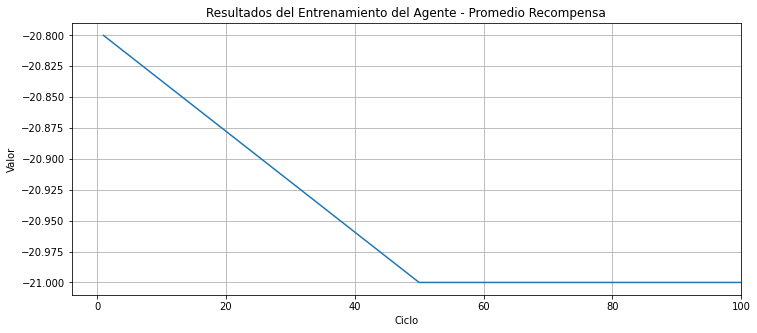

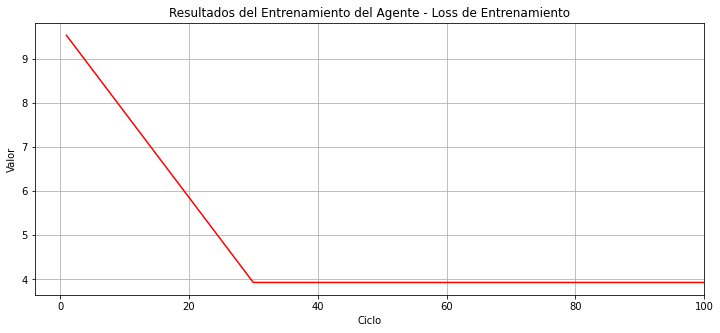

In [10]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN


if entrenar_DQN:

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloR, ar_returns)
  plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloR))   
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloL, ar_loss, color="red" )
  plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloL))   
  plt.grid(True)
  plt.show()


In [11]:
#@title Probar el Agente DQN Entrenado 

generar_animacion_policy(eval_env, eval_py_env, DQNpolicy, "DQNpolicy", True, 1)

Generando...
Recompensa Acumulada:  -21.0
Recompensa Final:  0.0


In [12]:
#@title Cargar o Guardar el Agente DQN entrenado

# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-Atari" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  import os
  from google.colab import drive
  from tf_agents.policies import TFPolicy, policy_saver
  # determina lugar donde se guarda el modelo
  policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)
  policy_dir = os.path.join(policy_dir, gym_env_name)
  # Montar Drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  if (DQNpolicy is not None) and isinstance(DQNpolicy, TFPolicy):
    # guarda la politica del agente DQN entrenado
    tf_policy_saver = policy_saver.PolicySaver(DQNpolicy)
    tf_policy_saver.save(policy_dir)
    print("\nPolítica DQN guardada en ", policy_dir)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  DQNpolicy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica DQN recuperada de ", policy_dir)
